# <span style="color:#1E88E5">XGBoost for Hurst Exponent Forecasting (over multiple days) </span> - Step by Step Tutorial

This notebook provides a detailed walkthrough of `train_hurst.py`, a script that computes the rolling Hurst exponent of a time series and trains/evaluates an XGBoost model to forecast its future values.

## <span style="color:#43A047">What is the Hurst Exponent?</span>

<div style="background-color:#EFF8FB; max-width: 700px; padding:15px; border-radius:10px; border-left:5px solid #4682B4">
The Hurst exponent is a measure used in time series analysis that quantifies the long-term memory of a series. It helps determine if a time series is:
<ul>
  <li><span style="color:#F44336"><b>H < 0.5</b></span>: Anti-persistent (mean-reverting)</li>
  <li><span style="color:#9E9E9E"><b>H = 0.5</b></span>: Random walk (no memory)</li>
  <li><span style="color:#4CAF50"><b>H > 0.5</b></span>: Trend-reinforcing (persistent)</li>
</ul>
</div>

## <span style="color:#43A047">What This Notebook Covers</span>

<div style="display: flex; flex-wrap: wrap; gap: 10px; margin-top: 10px">
  <div style="flex: 1; min-width: 100px; background-color:#E3F2FD; padding:10px; border-radius:5px">📚 <b>1.</b> Importing libraries</div>
  <div style="flex: 1; min-width: 150px; background-color:#E8F5E9; padding:10px; border-radius:5px">📈 <b>2.</b> Computing rolling Hurst</div>
  <div style="flex: 1; min-width: 150px; background-color:#FFF8E1; padding:10px; border-radius:5px">💾 <b>3.</b> Loading financial data</div>
  <div style="flex: 1; min-width: 150px; background-color:#F3E5F5; padding:10px; border-radius:5px">⚙️ <b>4.</b> Creating lagged features</div>
  <div style="flex: 1; min-width: 150px; background-color:#E0F7FA; padding:10px; border-radius:5px">🧠 <b>5.</b> Training XGBoost model</div>
  <div style="flex: 1; min-width: 150px; background-color:#FFEBEE; padding:10px; border-radius:5px">🔍 <b>6.</b> Evaluating performance</div>
  <div style="flex: 1; min-width: 150px; background-color:#F1F8E9; padding:10px; border-radius:5px">🔮 <b>7.</b> Forecasting future values</div>
  <div style="flex: 1; min-width: 150px; background-color:#E8EAF6; padding:10px; border-radius:5px">🖥️ <b>8.</b> Interactive menu system</div>
</div>

Let's get started!

## <span style="color:#1E88E5">1. Imports and Configuration</span>
<hr style="height:1px;border:none;background-color:#1E88E5">

First, let's import all the necessary libraries and set up our basic configuration:

In [61]:
# Import necessary libraries for numerical operations, data manipulation, and visualization
import numpy as np                # For numerical computations (arrays, math functions)
import pandas as pd               # For data manipulation with DataFrames
import matplotlib.pyplot as plt   # For creating plots and visualizations
from pathlib import Path          # For handling file paths in a platform-independent way
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For model evaluation metrics
import logging                    # For logging status and debug messages
import joblib                     # For saving/loading Python objects (like our trained models)
from xgboost import XGBRegressor  # XGBoost regression model implementation

# Set up basic configuration
# How many days ahead to predict (forecast horizon)
HORIZON = 14

# Configure logging to show informational messages with timestamps
logging.basicConfig(
    level=logging.INFO,  # Show INFO level messages and above
    format='%(asctime)s - %(levelname)s - %(message)s'  # Include timestamp and message level
)
logger = logging.getLogger(__name__)

# Define paths for data files and model storage
# Since we're in a Jupyter notebook, we'll use the current working directory
notebook_dir = Path.cwd()
DATA_PATH = notebook_dir / 'data' / 'dataset3.csv'  # Path to raw CSV data
DATA_PICKLE = notebook_dir / 'data' / 'dataset3.pkl'  # Path to cached pickle data

# Create directory for saving trained models
MODELS_DIR = notebook_dir / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

print(f"Data will be accessed from: {DATA_PATH}")
print(f"Models will be stored in: {MODELS_DIR}")

Data will be accessed from: /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/data/dataset3.csv
Models will be stored in: /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/models


## <span style="color:#FF8F00">2. Computing the Rolling Hurst Exponent</span>
<hr style="height:1px;border:none;background-color:#FF8F00">

This function calculates the Hurst exponent using Rescaled Range (R/S) analysis over a rolling window. The Hurst exponent measures the long-term memory or persistence of a time series.

<div style="background-color:#FFF8E1; max-width: 700px; padding:15px; border-radius:10px; border-left:5px solid #FFB300">
<span style="font-size:1.1em">🔑 <b>Key Concepts:</b></span>
<ul>
  <li><b>Window size</b>: 2<sup>power</sup> determines how many data points we use for each calculation</li>
  <li><b>R/S Analysis</b>: Calculates the ratio of the range to the standard deviation at different time scales</li>
  <li><b>Slope of log-log plot</b>: The slope of the line relating log(R/S) to log(time scale) gives us the Hurst exponent</li>
</ul>
</div>

In [62]:
def compute_rolling_hurst(returns: np.ndarray, power: int) -> np.ndarray:
    """
    Calculate the Hurst exponent using R/S analysis over a rolling window of size 2^power.
    
    Parameters:
    -----------
    returns : np.ndarray
        Time series data (e.g., asset returns) to analyze
    power : int
        Power of 2 to determine window size (window size = 2^power)
        
    Returns:
    --------
    np.ndarray
        Array of Hurst exponents calculated over rolling windows
    """
    # Convert input to numpy array if it's not already
    if not isinstance(returns, np.ndarray):
        returns = np.array(returns)
        
    # Validate the power parameter
    if not isinstance(power, int) or power < 1:
        raise ValueError("power must be a positive integer")
        
    # Calculate window length as 2^power
    n = 2**power
    
    # Check if we have enough data
    if len(returns) < n:
        raise ValueError(f"Need at least {n} data points for power={power}")
        
    # Initialize list to store Hurst exponents
    hursts = []
    
    # Define the range of exponents for multi-scale analysis
    # (from 2 to power, these will be our different time scales)
    exponents = np.arange(2, power+1)
    
    # Roll the window through the data
    for t in range(n, len(returns) + 1):
        # Get current window of data
        window = returns[t-n:t]
        
        # Store log values of R/S at different scales
        rs_log = []
        
        # Calculate R/S at different time scales
        for exp in exponents:
            # Size of each segment at this scale
            m = 2**exp
            
            # Number of segments
            s = n // m
            
            # Reshape data into segments
            segments = window.reshape(s, m)
            
            # Calculate cumulative deviation from mean for each segment
            dev = np.cumsum(
                segments - segments.mean(axis=1, keepdims=True),
                axis=1
            )
            
            # Range (R) is max deviation minus min deviation
            R = dev.max(axis=1) - dev.min(axis=1)
            
            # Standard deviation (S) of each segment
            S = segments.std(axis=1)
            
            # Calculate R/S ratio (avoid division by zero)
            rs = np.where(S != 0, R/S, 0)
            
            # Store log2 of mean R/S value
            rs_log.append(np.log2(rs.mean()))
        
        # Fit a line to log(R/S) vs log(time scale)
        # The slope of this line is the Hurst exponent
        hursts.append(np.polyfit(exponents, rs_log, 1)[0])
        
    return np.array(hursts)

## <span style="color:#7B1FA2">3. Data Loading Function</span>
<hr style="height:1px;border:none;background-color:#7B1FA2">

<div style="background-color:#F3E5F5; width:95%; padding:15px; border-radius:10px; border-left:5px solid #7B1FA2">
This function handles loading the price dataset. It checks if a cached version exists (for faster loading) and otherwise loads from CSV.

<p style="margin-top:10px">
💡 <b>Pro tip:</b> Using pickle for caching data significantly improves loading speed for large datasets!
</p>
</div>

In [63]:
def load_data() -> pd.DataFrame:
    """
    Load the price dataset from CSV or cache, sort by date,
    and return a pandas DataFrame.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing price data sorted by date
    """
    # First, check if a cached (pickled) version of the data exists
    if DATA_PICKLE.exists():
        # Load from the pickle file (much faster than CSV)
        df = pd.read_pickle(DATA_PICKLE)
        logger.info(f"Loaded data from cache: {DATA_PICKLE}")
    else:
        # If no cache exists, load from CSV
        df = pd.read_csv(
            DATA_PATH,
            parse_dates=['date'],  # Convert 'date' column to datetime
            low_memory=False       # Avoid warnings for mixed data types
        )
        # Sort the data by date
        df.sort_values('date', inplace=True)
        
        # Cache the data for faster future loading
        df.to_pickle(DATA_PICKLE)
        logger.info(f"Saved data to cache: {DATA_PICKLE}")
        
    return df

## <span style="color:#26A69A">4. Creating Lagged Features for Time Series Forecasting</span>
<hr style="height:1px;border:none;background-color:#26A69A">

This function creates lagged features for time series forecasting. Lagged features are simply past values of the time series that are used to predict future values.

<div style="display: flex; justify-content: center; margin: 20px 0;">
  <div style="background-color:#E0F2F1; padding:15px; border-radius:10px; width:90%">
    <span style="color:#00695C; font-weight:bold">Key Concepts:</span>
    <table style="width:100%; border-collapse: collapse; margin-top: 10px">
      <tr style="background-color:#B2DFDB">
        <th style="padding:8px; text-align:left">Concept</th>
        <th style="padding:8px; text-align:left">Description</th>
      </tr>
      <tr>
        <td style="padding:8px; border-bottom:1px solid #ddd"><b>Lag</b></td>
        <td style="padding:8px; border-bottom:1px solid #ddd">Using past values (t-1, t-2, ..., t-k) to predict the current value (t)</td>
      </tr>
      <tr>
        <td style="padding:8px; border-bottom:1px solid #ddd"><b>Feature Matrix X</b></td>
        <td style="padding:8px; border-bottom:1px solid #ddd">Each row contains k consecutive past values</td>
      </tr>
      <tr>
        <td style="padding:8px"><b>Target Vector y</b></td>
        <td style="padding:8px">Contains the value we want to predict (the value at time t)</td>
      </tr>
    </table>
  </div>
</div>

In [64]:
def make_lagged_features(series: pd.Series, k: int):
    """
    Generate lagged features matrix X and target vector y from a time series.
    
    Parameters:
    -----------
    series : pd.Series
        Time series data to create lagged features from
    k : int
        Number of lagged values to use as features
        
    Returns:
    --------
    (np.ndarray, np.ndarray)
        X: Feature matrix where each row contains k consecutive past values
        y: Target vector containing the values to predict
    """
    # Convert series to a numpy array for faster processing
    vals = series.values
    
    # Initialize empty lists for features and targets
    X, y = [], []
    
    # For each point in the time series (starting from position k)
    for i in range(k, len(vals)):
        # Add the k previous values as features
        X.append(vals[i-k:i])
        # Add the current value as the target
        y.append(vals[i])
    
    # Convert lists to numpy arrays and return
    return np.array(X), np.array(y)

## <span style="color:#00897B">5. Training an XGBoost Model</span>
<hr style="height:1px;border:none;background-color:#00897B">

This function trains an XGBoost regression model on lagged values of the Hurst exponent series.

<div style="background-color:#E0F2F1; max-width:1200px; padding:15px; border-radius:10px; border-left:5px solid #00897B">
<span style="font-size:1.1em">🔑 <b>Key Concepts:</b></span>

<div style="display: flex; flex-wrap: wrap; gap: 10px; margin-top: 10px">
  <div style="flex: 1; min-width: 200px; background-color:#B2DFDB; padding:10px; border-radius:5px">
    <b>XGBoost</b><br>A powerful gradient boosting algorithm that often achieves state-of-the-art results
  </div>
  <div style="flex: 1; min-width: 200px; background-color:#B2DFDB; padding:10px; border-radius:5px">
    <b>Train/Test Split</b><br>Dividing the data into a training set and test set based on time
  </div>
  <div style="flex: 1; min-width: 200px; background-color:#B2DFDB; padding:10px; border-radius:5px">
    <b>Model Saving</b><br>Saving the trained model to disk for later use
  </div>
</div>
</div>

In [65]:
def train_xgb_only(hurst_series: pd.Series, train_frac: float, k: int, xgb_params: dict):
    """
    Train a pure XGBoost model on lagged Hurst series.
    
    Parameters:
    -----------
    hurst_series : pd.Series
        Series of Hurst exponent values
    train_frac : float
        Fraction of data to use for training (0 to 1)
    k : int
        Number of lagged values to use as features
    xgb_params : dict
        Parameters for the XGBoost model
        
    Returns:
    --------
    XGBRegressor
        Trained XGBoost model
    """
    # Split data into training and test sets based on time
    # (first train_frac portion for training)
    split = int(len(hurst_series) * train_frac)
    train = hurst_series.iloc[:split]
    
    # Create lagged features for training data
    X_tr, y_tr = make_lagged_features(train, k)
    
    # Initialize and train the XGBoost model
    xgb_only = XGBRegressor(**xgb_params)
    xgb_only.fit(X_tr, y_tr)
    
    # Save the trained model to disk for later use
    joblib.dump(xgb_only, MODELS_DIR / 'xgb_only.pkl')
    logger.info("Pure XGBoost model saved to %s", MODELS_DIR)
    
    return xgb_only

## <span style="color:#D81B60">6. Evaluating Model Performance</span>
<hr style="height:1px;border:none;background-color:#D81B60">

This function evaluates the trained XGBoost model on the test set and visualizes the results.

<div style="display: flex; justify-content: space-between; flex-wrap: wrap; gap: 15px; margin: 15px 0;">
  <div style="flex: 1; min-width: 200px; background-color:#FCE4EC; padding:15px; border-radius:10px; border-top:4px solid #D81B60">
    <h4 style="margin-top:0; color:#AD1457">Test Set</h4>
    <p>Using unseen data to evaluate model performance is crucial for assessing how well the model will perform on new data.</p>
  </div>
  <div style="flex: 1; min-width: 200px; background-color:#FCE4EC; padding:15px; border-radius:10px; border-top:4px solid #D81B60">
    <h4 style="margin-top:0; color:#AD1457">Error Metrics</h4>
    <p>We use Mean Squared Error (MSE) and Mean Absolute Error (MAE) to quantify prediction accuracy.</p>
  </div>
  <div style="flex: 1; min-width: 200px; background-color:#FCE4EC; padding:15px; border-radius:10px; border-top:4px solid #D81B60">
    <h4 style="margin-top:0; color:#AD1457">Visualization</h4>
    <p>Plotting actual vs predicted values helps visually assess model performance and identify patterns.</p>
  </div>
</div>

In [66]:
def evaluate_xgb_only(hurst_series: pd.Series, xgb_only, k: int, test_frac: float):
    """
    Evaluate pure XGBoost model on test split and plot results.
    
    Parameters:
    -----------
    hurst_series : pd.Series
        Series of Hurst exponent values
    xgb_only : XGBRegressor
        Trained XGBoost model
    k : int
        Number of lagged values used as features
    test_frac : float
        Fraction of data to use for testing (0 to 1)
        
    Returns:
    --------
    (float, float)
        MSE and MAE on the test set
    """
    # Split data into training and test sets based on time
    # (last test_frac portion for testing)
    split = int(len(hurst_series) * (1 - test_frac))
    test = hurst_series.iloc[split:]
    
    # Create lagged features for test data
    X_te, y_te = make_lagged_features(test, k)
    
    # Use the model to make predictions on test data
    y_pred = xgb_only.predict(X_te)
    
    # Calculate error metrics
    mse = mean_squared_error(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    
    # Log the results
    logger.info("XGBoost-only results – MSE: %.4f, MAE: %.4f", mse, mae)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12,6))
    
    # Get dates for the test set (need to skip the first k points because of lagging)
    dates_te = test.index[k:]
    
    # Plot actual values
    plt.plot(dates_te, y_te, 'k-', label='Actual Hurst')
    
    # Plot predicted values
    plt.plot(dates_te, y_pred, 'g--', label='XGB-only Forecast')
    
    # Add title and labels
    plt.title('XGBoost-only: Actual vs Forecast Hurst Exponent')
    plt.xlabel('Date')
    plt.ylabel('Hurst Exponent')
    
    # Add legend, grid, and format plot
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return mse, mae

## <span style="color:#43A047">7. Forecasting Future Hurst Values</span>
<hr style="height:1px;border:none;background-color:#43A047">

This function generates future forecasts using the trained XGBoost model.

<div style="background-color:#E8F5E9; padding:20px; border-radius:10px; border-left:5px solid #43A047">
<span style="font-size:1.1em">🔑 <b>Key Concepts:</b></span>

<ul style="list-style-type: none; padding-left: 10px;">
  <li style="margin-bottom:10px; padding-left:25px; background: url('data:image/svg+xml;utf8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" viewBox="0 0 24 24" fill="none" stroke="%2343A047" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><path d="M22 11.08V12a10 10 0 1 1-5.93-9.14"></path><polyline points="22 4 12 14.01 9 11.01"></polyline></svg>') no-repeat left center;">
    <b>Recursive Forecasting</b>: Using predictions as inputs for future predictions
  </li>
  <li style="margin-bottom:10px; padding-left:25px; background: url('data:image/svg+xml;utf8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" viewBox="0 0 24 24" fill="none" stroke="%2343A047" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><path d="M22 11.08V12a10 10 0 1 1-5.93-9.14"></path><polyline points="22 4 12 14.01 9 11.01"></polyline></svg>') no-repeat left center;">
    <b>Forecast Horizon</b>: Number of future time periods to predict
  </li>
  <li style="padding-left:25px; background: url('data:image/svg+xml;utf8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" viewBox="0 0 24 24" fill="none" stroke="%2343A047" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"><path d="M22 11.08V12a10 10 0 1 1-5.93-9.14"></path><polyline points="22 4 12 14.01 9 11.01"></polyline></svg>') no-repeat left center;">
    <b>Visualization</b>: Plotting historical and forecasted values
  </li>
</ul>
</div>

In [67]:
def forecast_xgb_only(hurst_series: pd.Series, xgb_only, periods: int, k: int):
    """
    Generate future forecasts using pure XGBoost model recursively.
    
    Parameters:
    -----------
    hurst_series : pd.Series
        Series of Hurst exponent values
    xgb_only : XGBRegressor
        Trained XGBoost model
    periods : int
        Number of future periods to forecast
    k : int
        Number of lagged values used as features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with dates and forecasted values
    """
    # Create a copy of historical values to avoid modifying the original
    hist = list(hurst_series.values)
    
    # Initialize list to store predictions
    preds = []
    
    # Generate predictions for each future period
    for _ in range(periods):
        # If we don't have enough historical values yet, default to 0
        if len(hist) < k:
            p = 0
        else:
            # Use the model to predict the next value
            p = xgb_only.predict(np.array(hist[-k:]).reshape(1, -1))[0]
        
        # Store the prediction
        preds.append(p)
        
        # Add the prediction to historical values for recursive forecasting
        hist.append(p)
    
    # Generate future dates starting from the day after the last historical date
    # 'B' frequency means business days (Monday to Friday)
    dates = pd.date_range(
        hurst_series.index[-1] + pd.Timedelta(days=1), 
        periods=periods, 
        freq='B'
    )
    
    # Return DataFrame with dates and forecasts
    return pd.DataFrame({'ds': dates, 'yhat': np.array(preds)})

## <span style="color:#3949AB">8. Interactive Menu Function</span>
<hr style="height:1px;border:none;background-color:#3949AB">

<div style="background-color:#E8EAF6; padding:15px; border-radius:10px; border-left:5px solid #3949AB">
This function provides an interactive menu for users to choose what action to perform.

<span style="display:block; margin-top:10px; font-style:italic; color:#283593">💡 The menu makes it easy to train, evaluate, or generate forecasts with either custom or default parameters.</span>
</div>

In [68]:
def interactive_menu():
    """
    Display an interactive menu and get user's choice.
    
    Returns:
    --------
    str
        User's menu choice
    """
    # Display menu options
    print("Select action:")
    print("0: Train XGBoost model (interactive)")
    print("1: Evaluate XGBoost model (interactive)")
    print("2: Forecast XGBoost model (interactive)")
    print("4: Quick train XGBoost with defaults")
    print("5: Quick evaluate XGBoost with defaults")
    print("6: Quick forecast XGBoost with defaults")
    
    # Get user's choice
    choice = input("Enter choice (0,1,2,4,5,6): ")
    return choice

## <span style="color:#5E35B1">9. Main Function</span>
<hr style="height:1px;border:none;background-color:#5E35B1">

<div style="background-color:#EDE7F6; padding:15px; border-radius:10px; border-left:5px solid #5E35B1">
This is the main entry point of the program. It shows the menu, gets the user's choice, computes the Hurst series, and performs the requested action.

<span style="display:block; margin-top:10px; color:#4527A0">🚀 <b>Execution flow:</b> Display menu → Get user choice → Load data → Compute Hurst → Perform requested action</span>
</div>

In [69]:
def main():
    """
    Main entry point: show menu, get user choice, compute Hurst series,
    and train/evaluate/forecast the XGBoost model as requested.
    """
    # Log start of execution
    logger.info("Starting main execution...")
    
    # Display menu and get user's choice
    mode = interactive_menu().strip()
    
    # Validate user's choice
    if mode not in ['0','1','2','4','5','6']:
        logger.error("Invalid mode selected. Exiting.")
        return

    # Get parameters based on user's choice (interactive or defaults)
    if mode in ['0','1','2']:  # Interactive mode
        # Get user input for various parameters
        power = int(input("Enter power for rolling Hurst (default 6): ") or 6)
        ticker = input("Enter ticker (default AAPL): ") or 'AAPL'
        train_frac = float(input("Enter train fraction (default 0.8): ") or 0.8)
        test_frac = 1 - train_frac
        k = int(input("Enter lag depth k (default 5): ") or 5)
        xgb_params = {
            'n_estimators': int(input("Enter n_estimators (100): ") or 100),
            'learning_rate': float(input("Enter learning_rate (0.1): ") or 0.1)
        }
        periods = int(input("Enter forecast days (default 14): ") or HORIZON)
    else:  # Default mode
        # Use default parameters
        power, ticker = 5, 'AAPL'
        train_frac, test_frac = 0.8, 0.2
        k = 5
        xgb_params = {'n_estimators': 100, 'learning_rate': 0.1}
        periods = HORIZON

    # Load data and filter by ticker symbol
    df_all = load_data()
    df_t = df_all[df_all['ticker'] == ticker].sort_values('date')
    returns = df_t['return'].values

    # Compute rolling Hurst exponent series
    hurst_vals = compute_rolling_hurst(returns, power)
    dates = df_t['date']
    start_index = 2**power - 1
    hurst_series = pd.Series(hurst_vals, index=dates[start_index:])

    # Execute requested action based on user's choice
    if mode in ['0', '4']:  # Train model
        train_xgb_only(hurst_series, train_frac, k, xgb_params)
    elif mode in ['1', '5']:  # Evaluate model
        xgb_only = joblib.load(MODELS_DIR / 'xgb_only.pkl')
        evaluate_xgb_only(hurst_series, xgb_only, k, test_frac)
    elif mode in ['2', '6']:  # Forecast
        xgb_only = joblib.load(MODELS_DIR / 'xgb_only.pkl')
        df_fc = forecast_xgb_only(hurst_series, xgb_only, periods, k)
        logger.info("XGBoost-only forecast:\n%s", df_fc)
        
        # Plot historical and forecasted values
        plt.figure(figsize=(12, 6))
        plt.plot(hurst_series.index, hurst_series.values, 'k-', label='Historical Hurst')
        plt.plot(df_fc['ds'], df_fc['yhat'], 'g--', label='Forecast')
        plt.title(f'{periods}-Day Hurst Forecast for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Hurst Exponent')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## <span style="color:#1976D2">10. Running the Script</span>
<hr style="height:1px;border:none;background-color:#1976D2">

<div style="background-color:#E3F2FD; padding:15px; border-radius:10px; border-left:5px solid #1976D2">
Now, let's run the script as if it were being run as a standalone Python file.

<span style="display:block; margin-top:10px; font-weight:bold; color:#1565C0">⚡ Note:</span> When you run the cell below, you'll be prompted to make a selection from the menu. Follow the instructions to train, evaluate, or forecast with the XGBoost model.
</div>

2025-05-12 11:24:30,315 - INFO - Starting main execution...


Select action:
0: Train XGBoost model (interactive)
1: Evaluate XGBoost model (interactive)
2: Forecast XGBoost model (interactive)
4: Quick train XGBoost with defaults
5: Quick evaluate XGBoost with defaults
6: Quick forecast XGBoost with defaults


2025-05-12 11:24:42,897 - INFO - Loaded data from cache: /Users/roshanshah1/Downloads/Optimal_Stopping_with_signatures-main/XGboost_Roshan/src/data/dataset3.pkl
2025-05-12 11:24:42,942 - INFO - XGBoost-only results – MSE: 0.0009, MAE: 0.0238


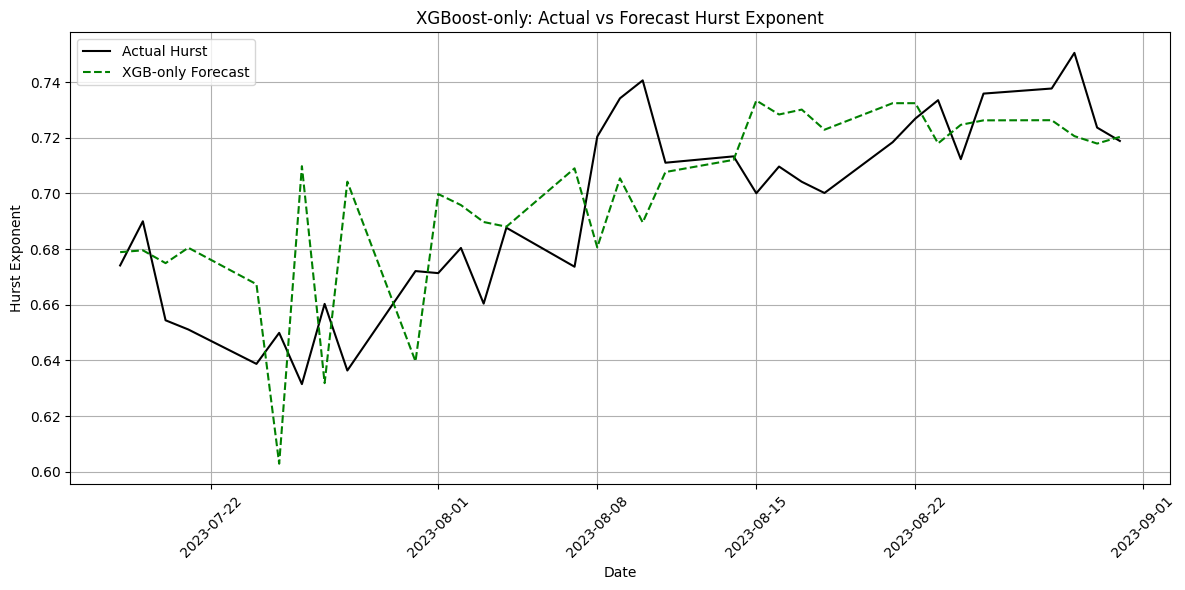

In [70]:
# This is equivalent to the `if __name__ == '__main__':` block in the original script
main()

## <span style="color:#EF6C00; font-size:1.4em">11. Summary</span>
<hr style="height:2px;border:none;background-color:#EF6C00">

This notebook has walked through all the components of the `train_hurst.py` script:

<div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 15px; margin: 20px 0;">
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">1. Computing the Hurst Exponent</h4>
    <p>We learned how to calculate the Hurst exponent using R/S analysis, which measures the long-term memory of a time series.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">2. Data Preparation</h4>
    <p>We loaded financial data, filtered by ticker symbol, and computed the rolling Hurst exponent.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">3. Feature Engineering</h4>
    <p>We created lagged features for time series forecasting to capture temporal patterns in the data.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">4. Model Training</h4>
    <p>We trained an XGBoost model to forecast future Hurst exponent values based on historical patterns.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">5. Model Evaluation</h4>
    <p>We evaluated the model's performance using MSE and MAE metrics, and visualized the results.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">6. Forecasting</h4>
    <p>We used the trained model to forecast future Hurst exponent values through recursive prediction.</p>
  </div>
  <div style="background-color:#FFF3E0; padding:15px; border-radius:10px; border-top:4px solid #EF6C00">
    <h4 style="margin-top:0; color:#E65100">7. Interactive Menu</h4>
    <p>We provided an interactive interface for users to choose what action to perform with custom parameters.</p>
  </div>
</div>
